In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as st
import statsmodels.api as sm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### 8.2 DATA GENERATION

In [2]:
np.random.seed(56)
n = 16
a = 40
b = -1.5
sigma = 5
x = np.arange(1, 17)
eps = st.norm.rvs(0, sigma, size = n)
y = a + b * x + eps

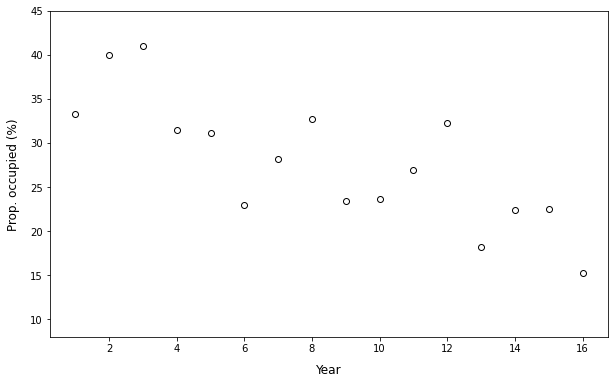

In [3]:
plt.figure(figsize = (10,6))
plt.scatter(x, y, edgecolor = 'k', facecolor = 'white')
plt.xlabel('Year', labelpad = 10, fontsize = 12)
plt.ylabel('Prop. occupied (%)', labelpad = 10, fontsize = 12)
plt.ylim(8, 45);

#### 8.4 ANALYSIS USING PyMC3

In [4]:
with pm.Model() as model_8_4:
    alpha = pm.Normal('alpha', 0, tau = 0.001)
    beta = pm.Normal('beta', 0, tau = 0.001)
    sigma = pm.Uniform('sigma', 0, 100)
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu, sigma, observed = y)
    residual = pm.Deterministic('residual', y - mu)
    pdecline = pm.Deterministic('pdecline', pm.math.where(beta >= 0, 0, 1))
    fit = pm.Deterministic('fit', pm.math.sum(pm.math.sqr(residual)))
    trace_8_4 = pm.sample(3000, target_accept = 0.97, return_inferencedata = True)
    
    y_new = pm.sample_posterior_predictive(trace_8_4)
    data_aux = az.from_pymc3(posterior_predictive = y_new)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 29 seconds.


In [5]:
trace_8_4.extend(data_aux)

In [6]:
az.summary(trace_8_4, var_names = ['alpha', 'beta', 'sigma', 'fit'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,37.751,2.715,32.370,42.574,0.064,0.045,1857.0,1990.0,1.0
beta,-1.173,0.279,-1.710,-0.658,0.007,0.005,1804.0,2081.0,1.0
sigma,5.065,1.063,3.332,7.095,0.022,0.016,2341.0,2822.0,1.0
fit,352.852,64.537,299.704,453.958,1.560,1.103,1940.0,2217.0,1.0


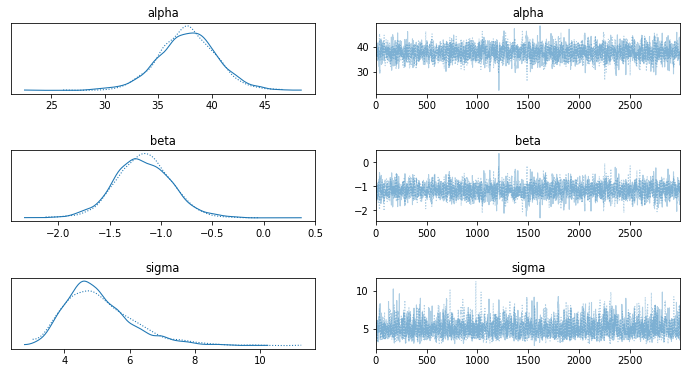

In [7]:
az.plot_trace(trace_8_4, var_names = ['alpha', 'beta', 'sigma'])
plt.subplots_adjust(hspace = 0.8, wspace=0.2);

### 8.4.2 Goodness-of-fit

#### Residual Plots

In [8]:
residual = trace_8_4.posterior.stack(samples = {'chain', 'draw'})['residual'].values
predicted = trace_8_4.posterior.stack(samples = {'chain', 'draw'})['mu'].values

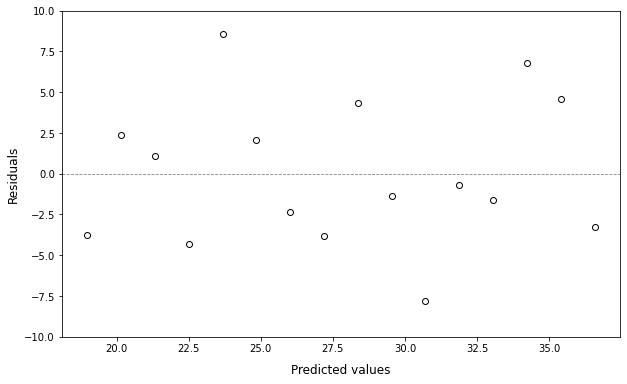

In [9]:
plt.figure(figsize = (10,6))
plt.axhline(y = 0, xmin = 0, xmax = 41, ls = '--', color = 'k', alpha = 0.5, lw = 0.8)
plt.ylim(-10, 10)
plt.scatter(predicted.mean(axis = 1), residual.mean(axis = 1), edgecolor = 'k', facecolor = 'white')
plt.xlabel('Predicted values', fontsize = 12, labelpad = 10)
plt.ylabel('Residuals', fontsize = 12);

#### Posterior Predictive Distributions and Bayesian p-Values

In [10]:
y_new = trace_8_4.posterior_predictive.stack(samples = {'chain', 'draw'})['y_pred'].values

In [12]:
#fit_ = (residual**2).mean(axis = 1).sum()
sq_new = (y_new - predicted)**2
fit_new = sq_new.mean(axis = 1).sum()
#print(fit_, fit_new)
bpvalue = (sq_new > residual**2).mean()
print('Bayesian p-value =', bpvalue)

Bayesian p-value = 0.5335729166666666


In [13]:
fit = trace_8_4.posterior.stack(samples = {'chain', 'draw'})['fit'].values

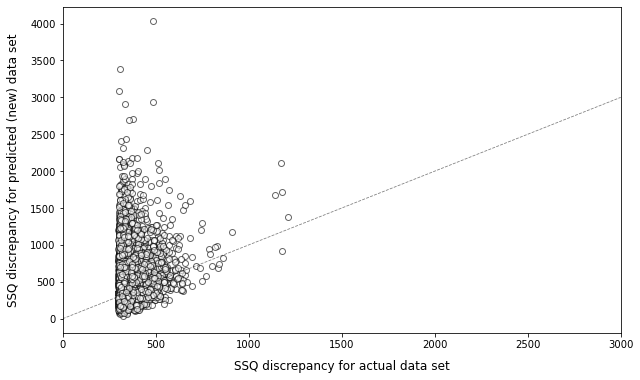

In [14]:
plt.figure(figsize = (10,6))
plt.axline((10, 10), ls = '--', color = 'k', slope=1, alpha = 0.5, lw = 0.8)
plt.scatter(fit, sq_new.sum(axis = 0), edgecolor = 'k', facecolor = 'white', alpha = 0.6)
plt.xlabel('SSQ discrepancy for actual data set', fontsize = 12, labelpad = 10)
plt.ylabel('SSQ discrepancy for predicted (new) data set', fontsize = 12, labelpad = 10)
plt.xlim(0, 3000);

### 8.4.3 Forming predictions

**FIGURE 8.4**

In [15]:
alphas = trace_8_4.posterior.stack(samples = {'chain', 'draw'})['alpha'].values
betas = trace_8_4.posterior.stack(samples = {'chain', 'draw'})['beta'].values

In [16]:
X = sm.add_constant(x)
model_mle = sm.OLS(y, X).fit()

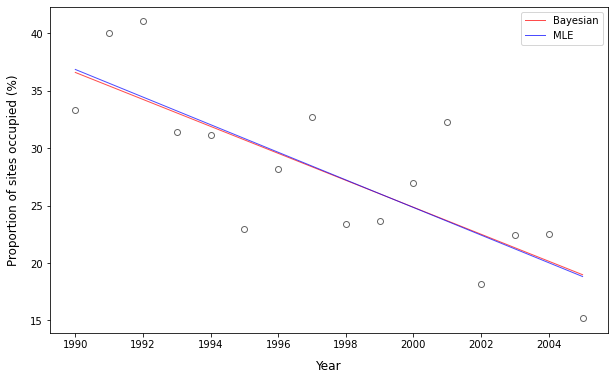

In [17]:
plt.figure(figsize = (10,6))
plt.plot(x + 1989, alphas.mean() + betas.mean() * x, lw = 1, color = 'red', alpha = 0.7, label = 'Bayesian')
plt.plot(x + 1989, model_mle.params[0] + model_mle.params[1] * x, lw = 1, color = 'blue', alpha = 0.7, label = 'MLE')
plt.scatter(x + 1989, y, edgecolor = 'black', facecolor = 'white', alpha = 0.6)
plt.xlabel('Year', fontsize = 12, labelpad = 10)
plt.ylabel('Proportion of sites occupied (%)', fontsize = 12, labelpad = 10)
plt.legend();

**FIGURE 8.5** Predicted wallcreeper trend (black) with 95% credible interval (red)

In [18]:
LPB = np.quantile(predicted, 0.025, axis = 1)
UPB = np.quantile(predicted, 0.975, axis = 1)

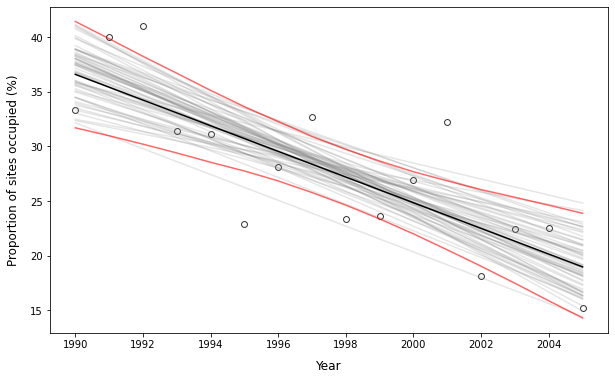

In [19]:
idx = range(0, predicted.shape[1], 100)
plt.figure(figsize = (10,6))
plt.plot(x + 1989, alphas[idx] + betas[idx] * x[:,np.newaxis], c='gray', alpha=0.2)
plt.plot(x + 1989, alphas.mean() + betas.mean() * x, color = 'k')
plt.plot(x + 1989, LPB, color = 'r', alpha = 0.6)
plt.plot(x + 1989, UPB, color = 'r', alpha = 0.6)
plt.scatter(x + 1989, y, edgecolor = 'k', s = 35, facecolor = 'white', alpha = 0.8)
plt.xlabel('Year', fontsize = 12, labelpad = 10)
plt.ylabel('Proportion of sites occupied (%)', fontsize = 12, labelpad = 10);

**FIGURE 8.6**

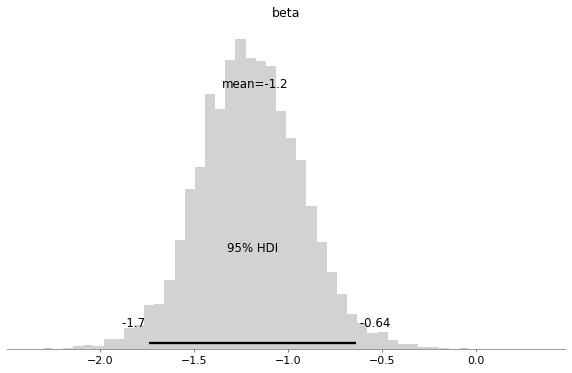

In [20]:
az.plot_posterior(trace_8_4, 
                  kind = 'hist', 
                  hdi_prob = 0.95, 
                  bins = 50, 
                  var_names = ['beta'], 
                  figsize = (10, 6), 
                  textsize=11,
                  color = 'gray');